# Playing with model described in https://arxiv.org/abs/1610.02415

In [1]:
import pandas as pd
import h5py
import numpy as np
from molecules.model import MoleculeVAE
from molecules.utils import one_hot_array, one_hot_index, decode_smiles_from_indexes

# number of dimensions to represent the molecules
# as the model was trained with this number, any operation made with the model must share the dimensions.
latent_dim = 292

# csv with some smiles
smiles_file = 'eloy_mols.csv'
# data used to train the model
data_used = 'data/chembl_22_processed.h5'
# file to save encoded smiles
smiles_file_encoded = 'eloy_mols_encoded.h5'
# trained_model 0.95 validation accuracy
# trained with 80% of ALL chembl molecules, validated on the other 20.
trained_model = 'models_saved/chembl_22_model_095.h5'

Using TensorFlow backend.


# Preprocess your molecules

In [2]:
# load charset from data used to train the model
# we need to use the charset of ALL training dataset, not only charset from our new input molecules
h5f = h5py.File(data_used, 'r')
charset =  list(h5f['charset'][:])
h5f.close()

# --------------------------------------------------

df = pd.read_csv(smiles_file)
structures = df['canonical_smiles'].map(lambda x: list(x.ljust(120)))

one_hot_encoded_fn = lambda row: map(lambda x: one_hot_array(x, len(charset)), one_hot_index(row, charset))
data = np.array(map(one_hot_encoded_fn, structures))

# Encode pre-processed molecules!

In [3]:
# Load model
model = MoleculeVAE()
model.load(charset, trained_model, latent_rep_size = latent_dim)

# Encode molecules
x_latent = model.encoder.predict(data)

# Save encoded molecules
h5f = h5py.File(smiles_file_encoded, 'w')
h5f.create_dataset('charset', data = charset)
h5f.create_dataset('latent_vectors', data = x_latent)
h5f.close()

# Show vectors of encoded molecules

In [4]:
print data

[[[0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]
  [0 1 0 ..., 0 0 0]
  ..., 
  [1 0 0 ..., 0 0 0]
  [1 0 0 ..., 0 0 0]
  [1 0 0 ..., 0 0 0]]

 [[0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]
  ..., 
  [1 0 0 ..., 0 0 0]
  [1 0 0 ..., 0 0 0]
  [1 0 0 ..., 0 0 0]]]


# Decode molecules

In [5]:
# Read encoded molecules file
h5f = h5py.File(smiles_file_encoded, 'r')
data = h5f['latent_vectors'][:]
charset =  h5f['charset'][:]
h5f.close()

model.load(charset, trained_model, latent_rep_size = latent_dim)

decoded_molecules = []
for m in data:
    decoded = model.decoder.predict(m.reshape(1, latent_dim)).argmax(axis=2)[0]
    decoded = decode_smiles_from_indexes(decoded, charset)
    decoded_molecules.append(decoded)

# Try to show decoded molecules with RDKit

In [6]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

/usr/local/lib/python2.7/dist-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


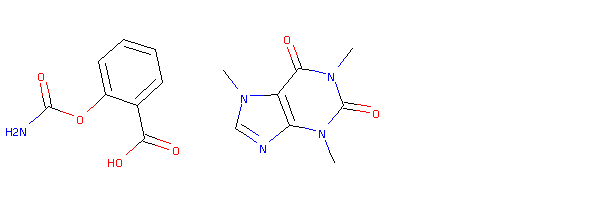

In [7]:
working_mols = []
for smiles in decoded_molecules:
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            working_mols.append(mol)
    except:
        continue
Draw.MolsToGridImage(working_mols)

# Show original mols

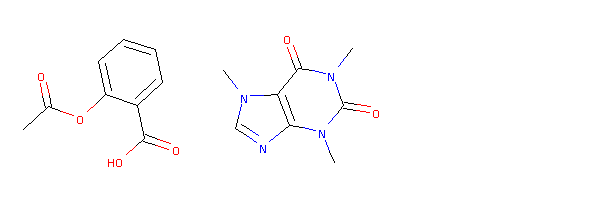

In [8]:
original_mols = []
for smiles in df['canonical_smiles']:
    try:
        mol = Chem.MolFromSmiles(smiles)
        original_mols.append(mol)
    except:
        continue
Draw.MolsToGridImage(original_mols)

# Generate molecules from random arrays

In [ ]:
import numpy as np

random_latent_mols = np.random.rand(10000, 292)

decoded_molecules = []
for m in random_latent_mols:
    decoded = model.decoder.predict(m.reshape(1, latent_dim)).argmax(axis=2)[0]
    decoded = decode_smiles_from_indexes(decoded, charset)
    decoded_molecules.append(decoded)

In [ ]:
working_mols = []
for smiles in decoded_molecules:
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            working_mols.append(mol)
    except:
        continue
print(len(working_mols))
Draw.MolsToGridImage(working_mols)

# Sample molecules near aspirin

In [9]:
aspirin_latent = data[0]
stdev = 0.2
test = stdev * np.random.randn(10000, 292) + aspirin_latent

In [10]:
decoded_molecules = []
for m in test:
    decoded = model.decoder.predict(m.reshape(1, latent_dim)).argmax(axis=2)[0]
    decoded = decode_smiles_from_indexes(decoded, charset)
    decoded_molecules.append(decoded)

259


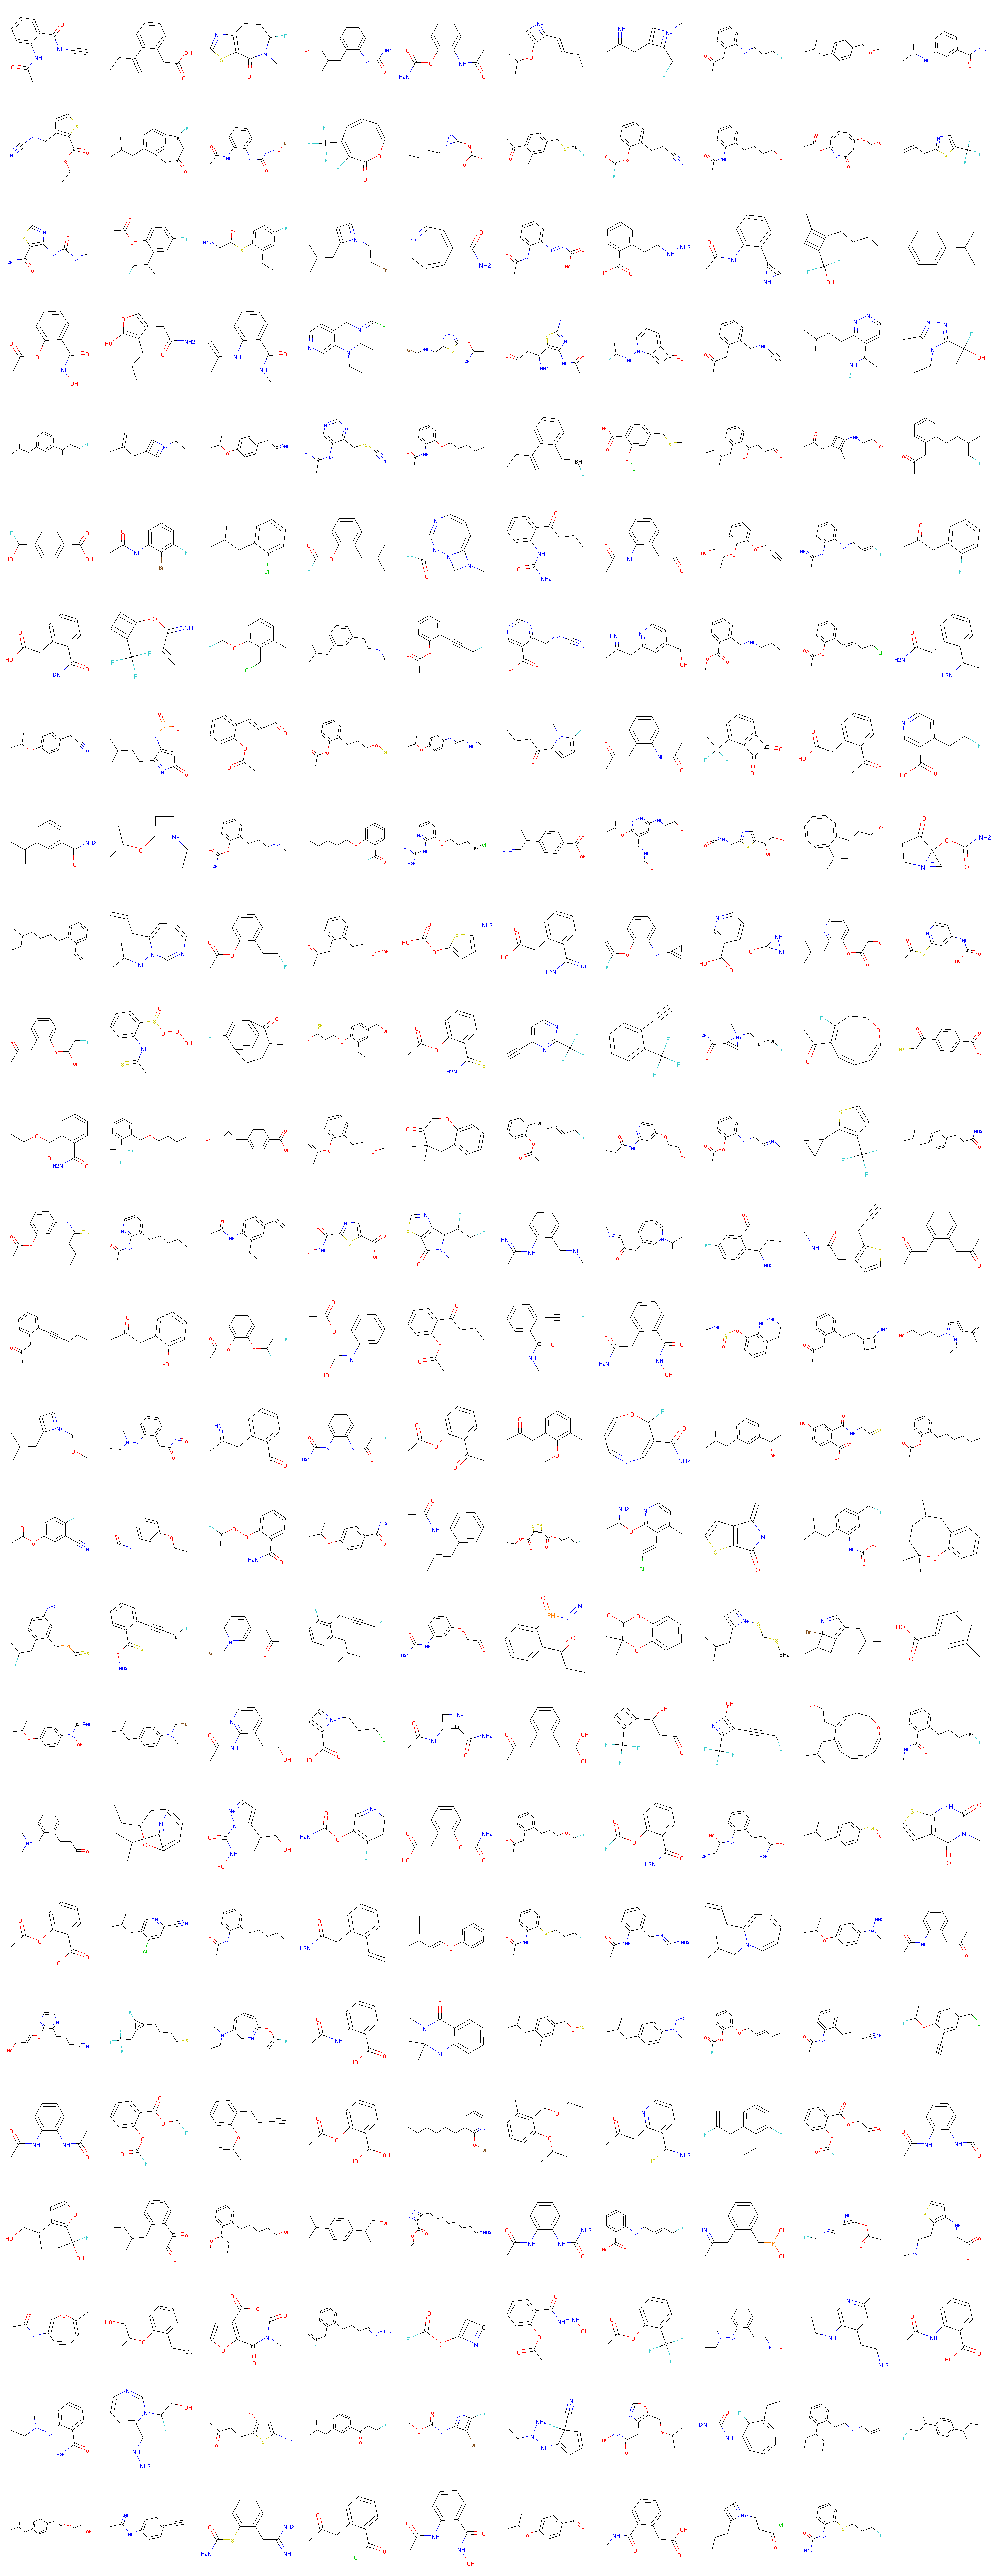

In [21]:
working_mols = []
for smiles in decoded_molecules:
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            working_mols.append(mol)
    except:
        continue
print(len(working_mols))
Draw.MolsToGridImage(working_mols, molsPerRow=10)

# Calc similarity

In [12]:
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols

ms = working_mols
ms.append(original_mols[0])
fps = [FingerprintMols.FingerprintMol(x) for x in ms]


0.253521126761
0.238188976378
0.263586956522
0.246575342466
0.31
0.309523809524
0.369973190349
0.431266846361
0.490990990991
0.380281690141
0.281144781145
0.283699059561
0.354166666667
0.204585537919
0.287234042553
0.37027027027
0.551622418879
0.427419354839
0.223706176962
0.35092348285
0.212903225806
0.475
0.228519195612
0.301630434783
0.266288951841
0.372093023256
0.453757225434
0.245283018868
0.18671454219
0.472
0.58904109589
0.23652173913
0.260550458716
0.212014134276
0.192377495463
0.247175141243
0.263908701854
0.367847411444
0.24025974026
0.241486068111
0.363076923077
0.292134831461
0.416129032258
0.211849192101
0.300202839757
0.384408602151
0.45652173913
0.407506702413
0.186219739292
0.372881355932
0.389067524116
0.368831168831
0.326086956522
0.55223880597
0.249340369393
0.267985611511
0.406593406593
0.39696969697
0.337110481586
0.365269461078
0.409214092141
0.20527306968
0.372340425532
0.326086956522
0.61094224924
0.248148148148
0.367021276596
0.309917355372
0.498812351544
0.35

In [20]:
sims = []
for fp in fps:
    sims.append(DataStructs.FingerprintSimilarity(fps[-1], fp))
high_sims = filter(lambda x: x >= 0.6, sims)
print len(high_sims), high_sims

12 [0.6109422492401215, 0.6211180124223602, 0.6280487804878049, 0.635483870967742, 0.6528497409326425, 0.6006006006006006, 1.0, 0.6433566433566433, 0.7380952380952381, 0.6355353075170843, 0.6160990712074303, 1.0]
